In [41]:
import numpy as np
import pandas as pd
from scipy import stats
from statsmodels.stats import weightstats as wsm
from statsmodels.stats.proportion import proportion_confint
from statsmodels.stats.weightstats import *
from scipy.stats import median_test
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

Анализ данных в задаче кредитного скоринга¶


Review Criteria: 
Выполнение каждого пункта задания должно начинаться с графика с данными, которые вы собираетесь анализировать. Еще лучше, если вы разложите графики анализируемого фактора по переменной (default), на которую хотите изучить влияние этого фактора, и проинтерпретируете отличия в полученных распределениях.
При использовании статистических критериев необходимо убедиться в том, что условия их применимости выполняются. Например, если вы видите, что данные бинарные, то не нужно применять критерий Стьюдента.
При каждом использовании любого критерия необходимо указать, какая проверяется гипотеза, против какой альтернативы, чему равен достигаемый уровень значимости, принимается или отвергается нулевая гипотеза на уровне значимости 0.05. Если задача позволяет, нужно оценить размер эффекта и предположить, имеет ли этот результат практическую значимость.

Задание
Размер кредитного лимита (LIMIT_BAL). В двух группах, тех людей, кто вернул кредит (default = 0) и тех, кто его не вернул (default = 1) проверьте гипотезы: a) о равенстве медианных значений кредитного лимита с помощью подходящей интервальной оценки; b) о равенстве распределений с помощью одного из подходящих непараметрических критериев проверки равенства средних. Значимы ли полученные результаты с практической точки зрения?
Пол (SEX). Проверьте гипотезу о том, что гендерный состав группы людей вернувших и не вернувших кредит отличается. Хорошо, если вы предоставите несколько различных решений этой задачи (с помощью доверительного интервала и подходящего статистического критерия).
Образование (EDUCATION). Проверьте гипотезу о том, что образование не влияет на то, вернет ли человек долг. Предложите способ наглядного представления разницы в ожидаемых и наблюдаемых значениях количества человек вернувших и не вернувших долг. Например, составьте таблицу сопряженности "образование" на "возврат долга", где значением ячейки была бы разность между наблюдаемым и ожидаемым количеством человек. Как бы вы предложили модифицировать таблицу так, чтобы привести значения ячеек к одному масштабу не потеряв в интерпретируемости? Наличие какого образования является наилучшим индикатором того, что человек отдаст долг? наоборт, не отдаст долг?
Семейное положение (MARRIAGE). Проверьте, как связан семейный статус с индикатором дефолта: нужно предложить меру, по которой можно измерить возможную связь этих переменных и посчитать ее значение.
Возраст (AGE). Относительно двух групп людей вернувших и не вернувших кредит проверьте следующие гипотезы: a) о равенстве медианных значений возрастов людей; b) о равенстве распределений с помощью одного из подходящих непараметрических критериев проверки равенства средних. Значимы ли полученные результаты с практической точки зрения?

Для выполнения этого задания вам понадобятся данные о кредитных историях клиентов одного из банков. Поля в предоставляемых данных имеют следующий смысл:

LIMIT_BAL: размер кредитного лимита (в том числе и на семью клиента)
SEX: пол клиента (1 = мужской, 2 = женский )
EDUCATION: образование (0 = доктор, 1 = магистр; 2 = бакалавр; 3 = выпускник школы; 4 = начальное образование; 5 = прочее; 6 = нет данных ).
MARRIAGE: (0 = отказываюсь отвечать; 1 = замужем/женат; 2 = холост; 3 = нет данных).
AGE: возраст в годах
PAY_0 - PAY_6 : История прошлых платежей по кредиту. PAY_6 - платеж в апреле, ..., PAY_0 - платеж в сентябре. Платеж = (0 = исправный платеж, 1 = задержка в один месяц, 2 = задержка в 2 месяца ...)
BILL_AMT1 - BILL_AMT6: задолженность, BILL_AMT6 - на апрель, ..., BILL_AMT1 - на сентябрь
PAY_AMT1 - PAY_AMT6: сумма уплаченная в PAY_AMT6 - апреле, ..., PAY_AMT1 - сентябре
default - индикатор невозврата денежных средств

In [92]:
data = pd.read_csv('credit_card_default_analysis.csv')
data.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default
0,1,20000,2,2,1,24,2,2,0,0,...,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2,2,26,0,2,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,90000,2,2,2,34,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,4,50000,2,2,1,37,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,5,50000,1,2,1,57,0,0,0,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


In [9]:
data.describe()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default
count,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,...,30000.000000,30000.000000,30000.000000,30000.000000,3.000000e+04,30000.00000,30000.000000,30000.000000,30000.000000,30000.000000
mean,15000.500000,167484.322667,1.603733,1.853133,1.551867,35.485500,0.356767,0.320033,0.304067,0.258767,...,43262.948967,40311.400967,38871.760400,5663.580500,5.921163e+03,5225.68150,4826.076867,4799.387633,5215.502567,0.221200
std,8660.398374,129747.661567,0.489129,0.790349,0.521970,9.217904,0.760594,0.801727,0.790589,0.761113,...,64332.856134,60797.155770,59554.107537,16563.280354,2.304087e+04,17606.96147,15666.159744,15278.305679,17777.465775,0.415062
min,1.000000,10000.000000,1.000000,0.000000,0.000000,21.000000,0.000000,0.000000,0.000000,0.000000,...,-170000.000000,-81334.000000,-339603.000000,0.000000,0.000000e+00,0.00000,0.000000,0.000000,0.000000,0.000000
25%,7500.750000,50000.000000,1.000000,1.000000,1.000000,28.000000,0.000000,0.000000,0.000000,0.000000,...,2326.750000,1763.000000,1256.000000,1000.000000,8.330000e+02,390.00000,296.000000,252.500000,117.750000,0.000000
50%,15000.500000,140000.000000,2.000000,2.000000,2.000000,34.000000,0.000000,0.000000,0.000000,0.000000,...,19052.000000,18104.500000,17071.000000,2100.000000,2.009000e+03,1800.00000,1500.000000,1500.000000,1500.000000,0.000000
75%,22500.250000,240000.000000,2.000000,2.000000,2.000000,41.000000,0.000000,0.000000,0.000000,0.000000,...,54506.000000,50190.500000,49198.250000,5006.000000,5.000000e+03,4505.00000,4013.250000,4031.500000,4000.000000,0.000000
max,30000.000000,1000000.000000,2.000000,6.000000,3.000000,79.000000,8.000000,8.000000,8.000000,8.000000,...,891586.000000,927171.000000,961664.000000,873552.000000,1.684259e+06,896040.00000,621000.000000,426529.000000,528666.000000,1.000000


In [12]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 25 columns):
ID           30000 non-null int64
LIMIT_BAL    30000 non-null int64
SEX          30000 non-null int64
EDUCATION    30000 non-null int64
MARRIAGE     30000 non-null int64
AGE          30000 non-null int64
PAY_0        30000 non-null int64
PAY_2        30000 non-null int64
PAY_3        30000 non-null int64
PAY_4        30000 non-null int64
PAY_5        30000 non-null int64
PAY_6        30000 non-null int64
BILL_AMT1    30000 non-null int64
BILL_AMT2    30000 non-null int64
BILL_AMT3    30000 non-null int64
BILL_AMT4    30000 non-null int64
BILL_AMT5    30000 non-null int64
BILL_AMT6    30000 non-null int64
PAY_AMT1     30000 non-null int64
PAY_AMT2     30000 non-null int64
PAY_AMT3     30000 non-null int64
PAY_AMT4     30000 non-null int64
PAY_AMT5     30000 non-null int64
PAY_AMT6     30000 non-null int64
default      30000 non-null int64
dtypes: int64(25)
memory usage: 5.7 MB


<function matplotlib.pyplot.show>

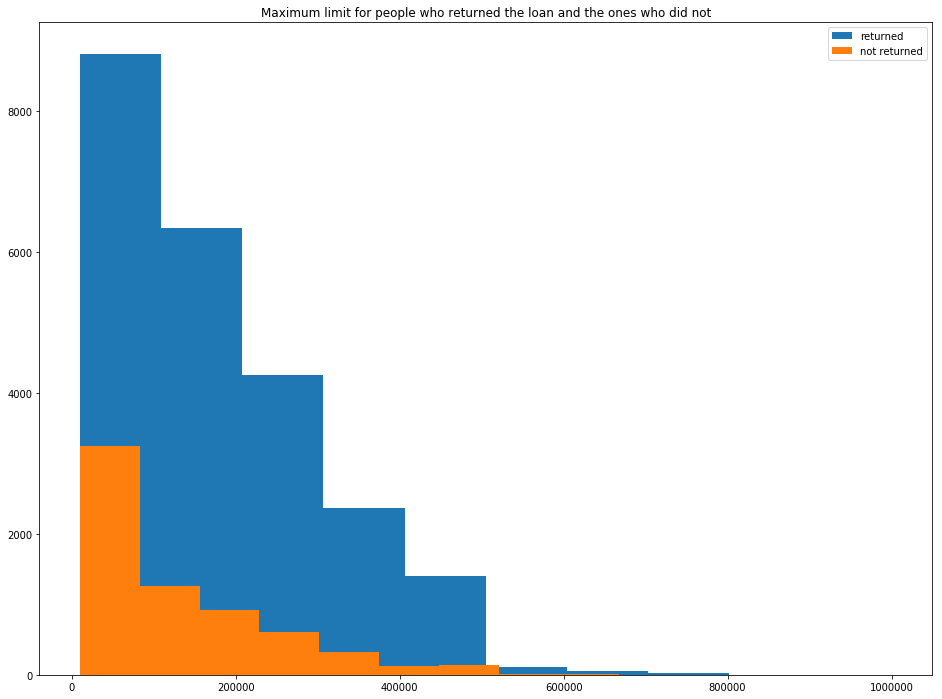

In [17]:
plt.figure(figsize=(16,12))
plt.title('Maximum limit for people who returned the loan and the ones who did not')
plt.hist(data.LIMIT_BAL.loc[data.default==0], label='returned')
plt.hist(data.LIMIT_BAL.loc[data.default==1], label='not returned')
plt.legend(loc='best')
plt.show

Проверим гипотезу о равенстве медианных значений кредитного лимита с помощью подходящей интервальной оценки.

H0: медианные значения равны


H1: медианные значения отличаются

In [57]:
default = data.LIMIT_BAL[data.default == 1].values
med1 = np.median(default)
notdefault = data.LIMIT_BAL[data.default == 0].values
med2 = np.median(notdefault)
med1, med2



(90000.0, 150000.0)

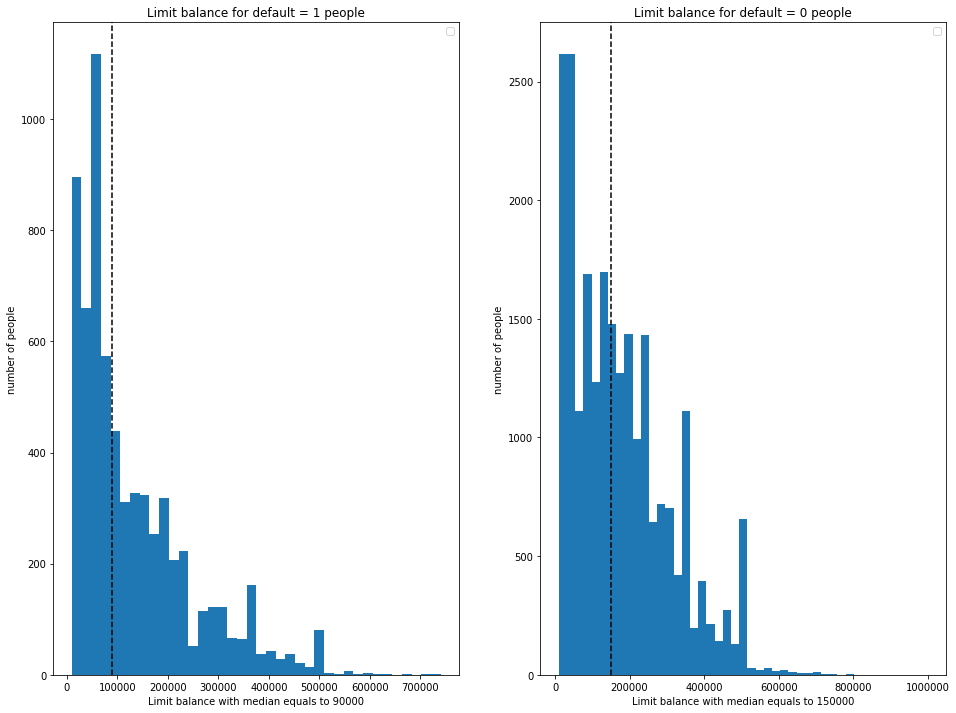

In [58]:
# Visualization method
plt.figure(figsize=(16,12))
plt.subplot(121)
plt.hist(default, bins=38)
plt.axvline(med1, color='black', linestyle='dashed')
plt.xlabel('Limit balance with median equals to %d' % med1)
plt.ylabel('number of people')
plt.title('Limit balance for default = 1 people')
plt.legend(loc='best')

plt.subplot(122)
plt.hist(notdefault, bins=45)
plt.axvline(med2, color='black', linestyle='dashed')
plt.xlabel('Limit balance with median equals to %d' % med2)
plt.ylabel('number of people')
plt.title('Limit balance for default = 0 people')
plt.legend(loc='best')


In [59]:
# Bootstrap method
def get_bootstrap_samples(data, n_samples):
    indices = np.random.randint(0, len(data), (n_samples, len(data)))
    samples = data[indices]
    return samples

In [60]:
def stat_intervals(stat, alpha=0.05):
    boundaries = np.percentile(stat, [100 * alpha / 2., 100 * (1 - alpha / 2.)])
    return boundaries

In [62]:
default_median_scores = np.median(get_bootstrap_samples(default, 1000), axis=1)
notdefault_median_scores = np.median(get_bootstrap_samples(notdefault, 1000), axis=1)

print "95% confidence interval for default = 1 clients:",  stat_intervals(default_median_scores)
print "95% confidence interval for default = 0 clients:",  stat_intervals(notdefault_median_scores)


95% confidence interval for default = 1 clients: [80000. 90000.]
95% confidence interval for default = 0 clients: [150000. 150000.]


так как интервалы не пересекаются и имеют разные значения, можно уверенно отвергнуть нулевую гипотезу!

In [67]:
# Формальное тому подтверждение с использованием теста Mуда для проверки гипотезы о равных медианах
print('p-value equals to {}'.format(median_test(default, notdefault)[1])) 

p-value equals to 1.34714180115e-150


Проверим теперь равенство распределений в двух выборках

H0: Средние значения одинаковые

H1: Средние значения разные


In [70]:
# Критерий Манна-Уитни, данный критерий работает при размере выборки больше 20 и, если выборки независимые.
print('p-value equals to {}'.format(stats.mannwhitneyu(default, notdefault)))

p-value equals to MannwhitneyuResult(statistic=59257217.5, pvalue=6.127742909111652e-190)


Нулевая гипотеза строго отвергается критерием Манна-Уитни! Следовательно средние значения лимита кредита для тех, кто вернул кредит и не вернул - разные и пришли из разных распределений!

Проверим теперь то же самое с помощью перестановочного критерия с максимальным количеством перестановок = 10000:

In [72]:
def permutation_test_ind(sample1, sample2, max_permutations=None, alternative='two-sided'):
    ''' Перестановочный критерий (независимые выборки)

    :param sample1: выборка 1
    :param sample2: выборка 2
    :param max_combinations: количество перестановок, None - все возможные
    :param alternative: альтернатива ['two-sided', 'less', 'greater']
    :return: достигаемый уровень значимости (p-value)
    '''

    if alternative not in ('two-sided', 'less', 'greater'):
        raise ValueError("alternative not recognized\n"
                         "should be 'two-sided', 'less' or 'greater'")

    t_stat = permutation_t_stat_ind(sample1, sample2)

    zero_distr = permutation_zero_dist_ind(sample1, sample2, max_permutations)

    if alternative == 'two-sided':
        return sum([1. if abs(x) >= abs(t_stat) else 0. for x in zero_distr]) / len(zero_distr)

    if alternative == 'less':
        return sum([1. if x <= t_stat else 0. for x in zero_distr]) / len(zero_distr)

    if alternative == 'greater':
        return sum([1. if x >= t_stat else 0. for x in zero_distr]) / len(zero_distr)

    
def permutation_t_stat_ind(sample1, sample2):
    return np.mean(sample1) - np.mean(sample2)


def get_random_combinations(n1, n2, max_combinations):
    index = list(range(n1 + n2))
    indices = set([tuple(index)])
    for i in range(max_combinations - 1):
        np.random.shuffle(index)
        indices.add(tuple(index))
    return [(index[:n1], index[n1:]) for index in indices]


def permutation_zero_dist_ind(sample1, sample2, max_combinations=None):
    joined_sample = np.hstack((sample1, sample2))
    n1 = len(sample1)
    n = len(joined_sample)

    if max_combinations:
        indices = get_random_combinations(n1, len(sample2), max_combinations)
    else:
        indices = [(list(index), filter(lambda i: i not in index, range(n))) \
                   for index in itertools.combinations(range(n), n1)]

    distr = [joined_sample[list(i[0])].mean() - joined_sample[list(i[1])].mean() \
             for i in indices]
    return distr

In [74]:

print "Достигаемый уровень значимости перестановочного критерия: %.5f" % permutation_test_ind(notdefault, default, max_permutations=10000)
                                                                         

Достигаемый уровень значимости перестановочного критерия: 0.00010


Результат имеет практическую значимость: Люди, занимающие не более 90000 требуют к себе особого внимания, так как должны попадать в группу особого контроля.

2. Проверка гипотезы о том, что гендерный состав группы людей вернувших и не вернувших кредит отличается

In [75]:
data.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default
0,1,20000,2,2,1,24,2,2,0,0,...,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2,2,26,0,2,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,90000,2,2,2,34,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,4,50000,2,2,1,37,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,5,50000,1,2,1,57,0,0,0,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


In [80]:
# Составим таблицу сопряженности для мужчин и женщин, кто вернул и не вернул кредиты и визуализируем ее
table = data.pivot_table(index='default', values="LIMIT_BAL", columns='SEX', aggfunc = len)
table

SEX,1,2
default,,
0,9015,14349
1,2873,3763


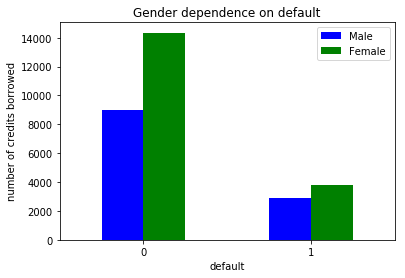

In [85]:
table.plot.bar(color = ['blue', 'green'], rot=False)
plt.xlabel('default')
plt.ylabel('number of credits borrowed')
plt.title('Gender dependence on default')
plt.legend(['Male', 'Female'])
plt.show()

Проверим гипотезу о том, что пол не зависит от возврата кредита, против альтернативы, о том, что гендерный состав отличается

In [100]:
def_sex = data[data.default == 1].SEX
notdef_sex = data[data.default == 0].SEX


Проверим гипотезу с помощью доверительного интервала для разности долей

In [101]:
def proportions_diff_confint_ind(sample1, sample2, alpha=0.05):
    ''' Доверительный интервал для разности долей (независимые выборки)

    :param sample1: выборка 1 с бинарными значениями [0, 1]
    :param sample2: выборка 2 с бинарными значениями [0, 1]
    :param alpha: уровень доверия
    :return: доверительный интервал для разности долей (левая_граница, правая_граница)
    '''

    z = stats.norm.ppf(1 - alpha / 2.)

    p1 = float(sum(sample1)) / len(sample1)
    p2 = float(sum(sample2)) / len(sample2)

    left_boundary = (p1 - p2) - z * np.sqrt(
        p1 * (1 - p1) / len(sample1) + p2 * (1 - p2) / len(sample2))
    right_boundary = (p1 - p2) + z * np.sqrt(
        p1 * (1 - p1) / len(sample1) + p2 * (1 - p2) / len(sample2))

    return (left_boundary, right_boundary)

In [107]:
alpha = 0.05
interval = proportions_diff_confint_ind(list(map(lambda x: 0 if x == 2 else x, notdef_sex)),
                                        list(map(lambda x: 0 if x == 2 else x, def_sex)), alpha)
print "%d confidence interval for a difference between proportions: [%.4f], [%.4f]" % ((1 - alpha) * 100, interval[0], interval[1])

95 confidence interval for a difference between proportions: [-0.0605], [-0.0336]


Так как в интервале не содержится нуля, можно сказать, что возврат кредита зависит от гендерного состава выборки

Докажем это с помощью критерия Фишера

In [112]:
print('p-value equals to %.12f' % stats.fisher_exact(table)[1])

p-value equals to 0.000000000005


На уровне значимости 0.05 можем отвергнуть гипотезу о том, что гендерный состав не влияет на возвращение кредита.

3. Проверка гипотезы о том, что образование не влияет на то, вернет ли человек долг

In [151]:
data.EDUCATION.value_counts()
educ_names = ['doctor of sciences', 'master', 'bachelor', 'school graduate', 'elementary education', 'other', 'N/A']

In [152]:
educ_0default = data[data.default == 0].EDUCATION.values
educ_1default = data[data.default == 1].EDUCATION.values
table_educ = data.pivot_table(index='default', values='LIMIT_BAL', columns='EDUCATION', aggfunc=len, fill_value = 0)
table_educ

EDUCATION,0,1,2,3,4,5,6
default,,,,,,,
0,14,8549,10700,3680,116,262,43
1,0,2036,3330,1237,7,18,8


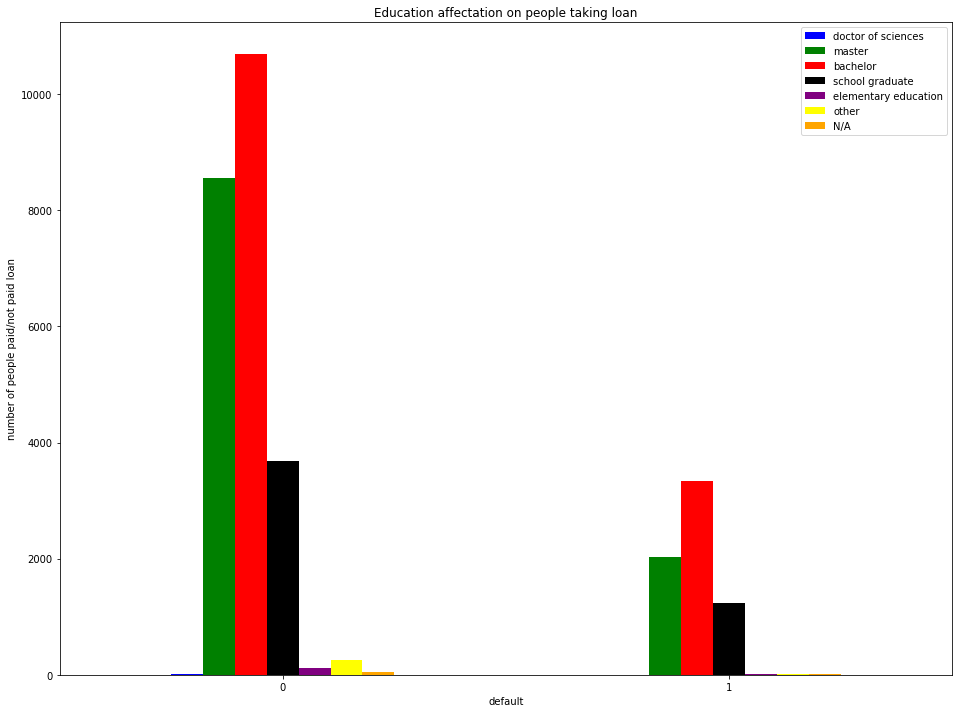

In [153]:

table_educ.plot.bar(figsize=(16,12), rot=0, color=['blue', 'green', 'red', 'black', 'purple', 'yellow', 'orange'])
plt.xlabel('default')
plt.ylabel('number of people paid/not paid loan')
plt.title('Education affectation on people taking loan')
plt.legend(educ_names, loc='best')
plt.show()

Проверку гипотезы будем осуществлять с помощью критерия хи-квадрат:



In [144]:
# Для использования данного критерия необходимо и достаточно, чтобы в выборке было более 40 объектов и 
# ожидаемое количество элеменов в таблице было не более 20%
print 'Количество объектов в таблице:', np.sum(np.array(table_educ))
print 'Часть элементов меньше 5:', 1.*np.sum(np.array(table_educ) < 5) / (table_educ.shape[0] * table_educ.shape[1])

Количество объектов в таблице: 30000
Часть элементов меньше 5: 0.0714285714286


$H_0$: уровень образования не влияет на возврат кредита


$H_1$: влияет

In [149]:
stat, p, _, _ = stats.chi2_contingency(table_educ)
print("chi2 contingency equals to {} and p-value equals to {}".format(stat, p))

chi2 contingency equals to 163.21655787 and p-value equals to 1.23326262454e-32


Нулевая гипотеза отвергается на достигаемом уровне значимости 0.05!

Визуализируем разницу между вернувшими и не вернувшими кредит

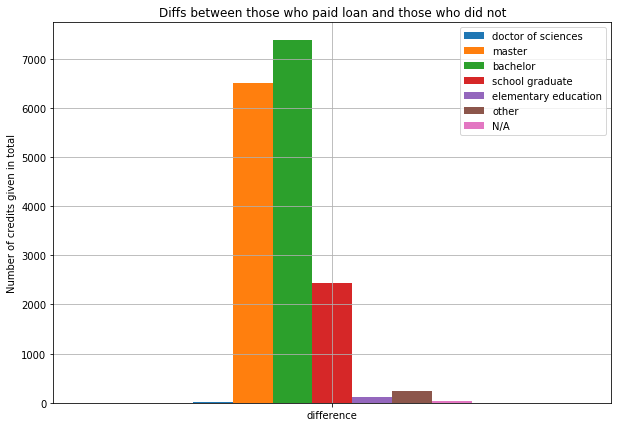

In [160]:
table_diff_educ = pd.DataFrame(data=np.array((table_educ.loc[0] - table_educ.loc[1])).reshape(1,7),
                               columns=table_educ.columns, index = ["difference"])

table_diff_educ.plot.bar(rot=0, figsize=(10, 7))
plt.ylabel("Number of credits given in total")
plt.title("Diffs between those who paid loan and those who did not")
plt.legend(educ_names)
plt.grid()
plt.show()

Приведём значения к одному масштабу. Для этого разделим каждое значение разности на количество людей в этой категории, таким образом выясним, что чем больше доля людей той или иной категории, тем лучше эта категория возвращает кредит.

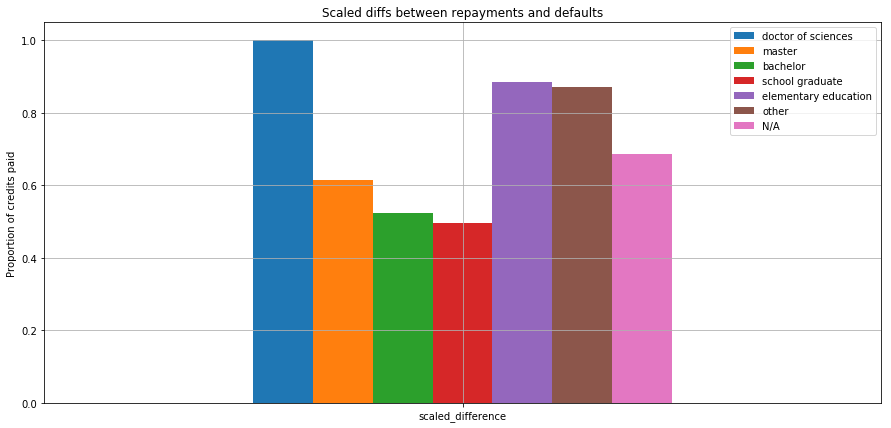

In [163]:
diff_educ_scaled = (table_educ.loc[0] - table_educ.loc[1]) / ((table_educ.loc[0] + table_educ.loc[1]))
table_diff_edu2_scaled = pd.DataFrame(data=np.array(diff_educ_scaled).reshape(1,7),
                                      columns=table_educ.columns, index = ["scaled_difference"])

table_diff_edu2_scaled.plot.bar(rot=0, figsize=(15, 7))
plt.ylabel("Proportion of credits paid")
plt.title("Scaled diffs between repayments and defaults")
plt.legend(educ_names)
plt.grid()
plt.show()

Таким образом, видно, что доктора наук, люди со дошкольным образованием, другими и неопределенными категориями отдают кредит лучше остальных. Однако количество данных ограничивает утдверждать данное удтверждение строго! В то время, как можно удтверждать, что магистры отдают кредит лучше чем люди со школьным образованием, и со степенью бакалавра!

4. Проверка связи семейного статуса с индикатором дефолта

In [168]:
data.MARRIAGE.value_counts()

2    15964
1    13659
3      323
0       54
Name: MARRIAGE, dtype: int64

In [171]:
marriage_types = ['refused_to_answer', 'married', 'single', 'N/A']
table_marr = data.pivot_table(index='default', values='LIMIT_BAL', columns='MARRIAGE', aggfunc = len, fill_value = 0)
table_marr

MARRIAGE,0,1,2,3
default,,,,
0,49,10453,12623,239
1,5,3206,3341,84


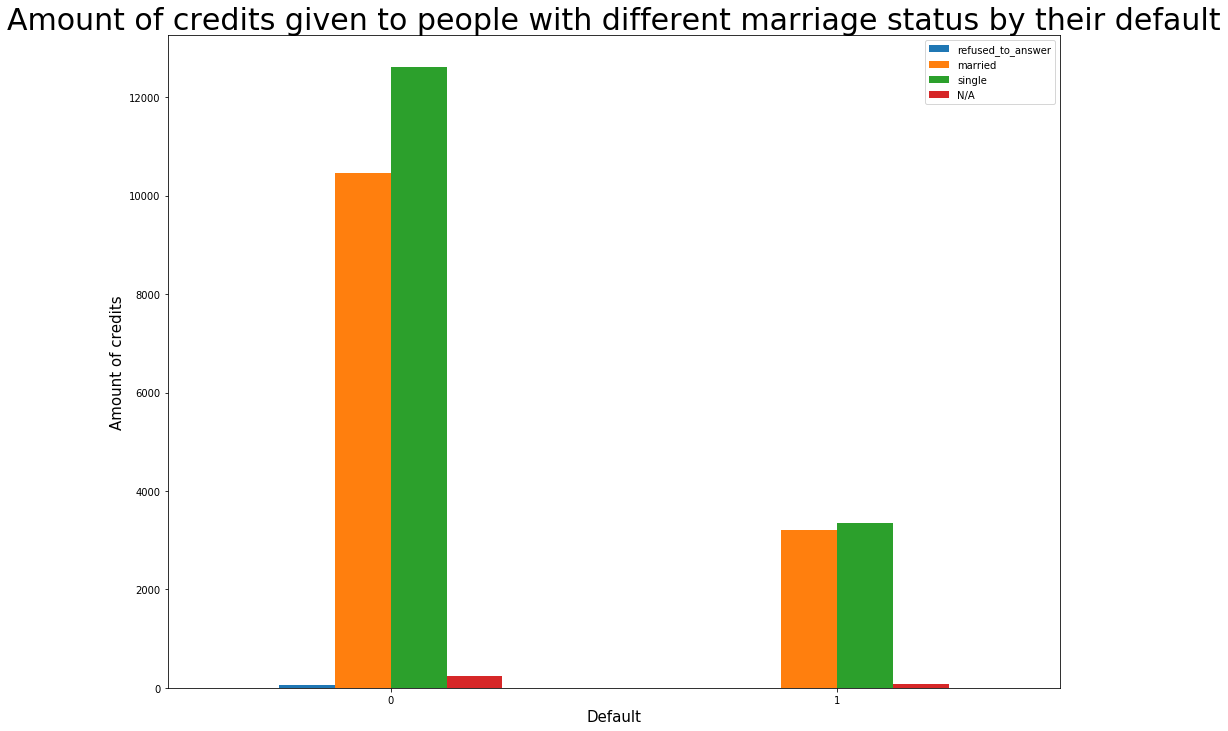

In [184]:
table_marr.plot.bar(figsize=(16,12), rot=0)
plt.xlabel('Default', size=15)
plt.ylabel('Amount of credits', size=15)
plt.title('Amount of credits given to people with different marriage status by their default', size=30)
plt.legend(marriage_types, loc='best')


Измерять корреляцию будем с помощью коэффициента V Крамера, предварительно проведя анализ критерия Хи-квадрат.

Проверим выполнение условий для применения критерия Хи-квадрат.


In [194]:
print 'The amount of experiments equals to %d ' % np.sum(np.array(table_marr))
print 'Portion of elements less than 5 is %.2f' % float(np.sum(np.array(table_marr) < 5) / (table_marr.shape[0] * table_marr.shape[1]))

The amount of experiments equals to 30000 
Portion of elements less than 5 is 0.00


Условия для применения критерия Хи-квадрат выполняются. 

In [202]:
stat, p_val, dof, exp = stats.chi2_contingency(table_marr)

n = 30000
V_Cramer_coef = (stat / n) ** 0.5

print 'Cramer\'s V = %.4f' % V_Cramer_coef
print 'p-value equals to {}'.format(p_val)

Cramer's V = 0.0345
p-value equals to 8.82586245758e-08


На уровне значимости 0.05 отвергаем нулевую гипотезу. Однако, коэффициент V Крамера не высок, что означает, что корреляция не высокая. 

5а. Проверка гипотезы о равенстве медианных значений возрастов людей.

In [206]:
data.AGE.unique()

array([24, 26, 34, 37, 57, 29, 23, 28, 35, 51, 41, 30, 49, 39, 40, 27, 47,
       33, 32, 54, 58, 22, 25, 31, 46, 42, 43, 45, 56, 44, 53, 38, 63, 36,
       52, 48, 55, 60, 50, 75, 61, 73, 59, 21, 67, 66, 62, 70, 72, 64, 65,
       71, 69, 68, 79, 74], dtype=int64)

In [224]:
age_1def = data[data.default == 1].AGE.values
age_0def = data[data.default == 0].AGE.values

34.0

H0: Медианы значений возрастов людей равны.

H1: Медианы значений возрастов людей не равны.

median of people categories with default 1 equals to 34.0000 
median of people categories with default 0 equals to 34.0000 


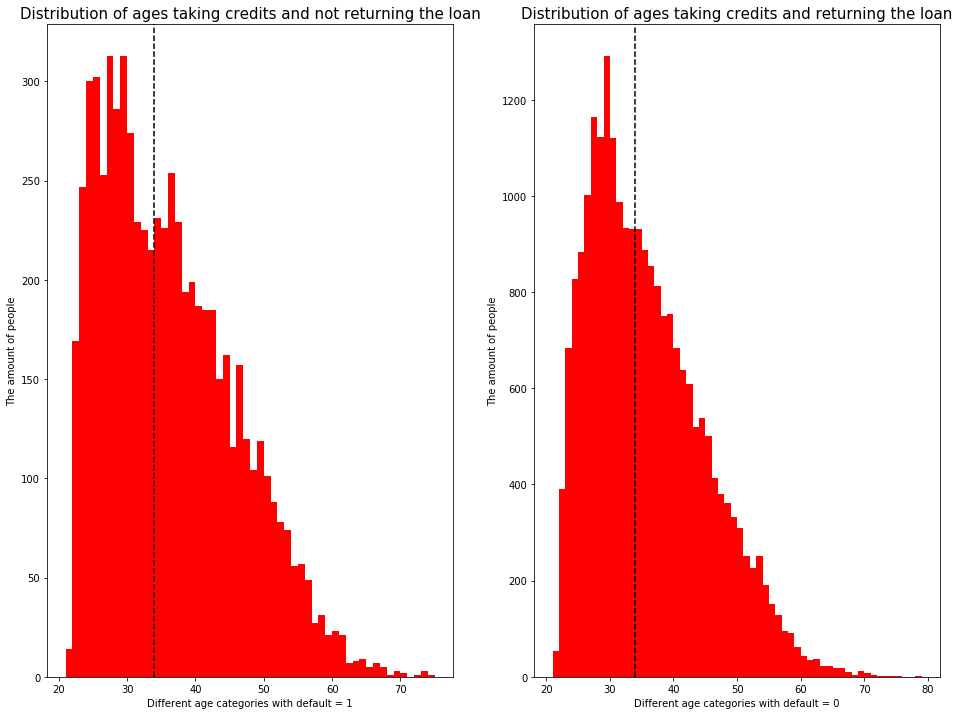

In [225]:
med_age_1def = np.median(age_1def)
med_age_0def = np.median(age_0def)
plt.figure(figsize=(16,12))
plt.subplot(121)
plt.hist(age_1def, bins=max(age_1def) - min(age_1def), color='red')
plt.axvline(med_age_1def, linestyle='dashed', color='black')
plt.xlabel('Different age categories with default = 1', size=10)
plt.ylabel('The amount of people', size=10)
plt.title('Distribution of ages taking credits and not returning the loan', size=15)


plt.subplot(122)
plt.hist(age_0def, bins=max(age_0def) - min(age_0def), color='red')
plt.axvline(med_age_0def, linestyle='dashed', color='black')
plt.xlabel('Different age categories with default = 0', size=10)
plt.ylabel('The amount of people', size=10)
plt.title('Distribution of ages taking credits and returning the loan', size=15)

print('median of people categories with default 1 equals to %.4f ' % med_age_1def)
print('median of people categories with default 0 equals to %.4f ' % med_age_0def)

Построим теперь доверительный интервал методом бутстрепа.

In [226]:
def_median_scores = np.median(get_bootstrap_samples(age_0def, 1000), axis=1)
nodef_median_scores = np.median(get_bootstrap_samples(age_1def, 1000), axis=1)

print "95% confidence interval for people not returning loans",  stat_intervals(def_median_scores)
print "95% confidence interval for people returning loans:",  stat_intervals(nodef_median_scores)

95% confidence interval for people not returning loans [34. 34.]
95% confidence interval for people returning loans: [34. 35.]


Из-за пересечения доверительный интервалов нельзя удтверждать, что медианы не равны.

Применим Критерий Манна-Уитни для проверки выборочных средних в двух выборках

H0: Средние равны

H1: Средние не равны

In [229]:
print('p-value equals to %.4f ' % stats.mannwhitneyu(age_1def, age_0def).pvalue)

p-value equals to 0.1863 


Исходя из полученного достигаемого уровня значимости мы не можем отвергать гипотезу, что средние равны!

Отсюда следует, что возраст не значим для скоринговой модели!